# 【問題1】クロスバリデーション
### 事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。
### 具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

＜戦略＞　※結局１回目にはできず
<li>欠損値補完の際、多重代入法、ランダムフォレスト補完を検討
<li>特徴量の意味を検討して加工を行う

In [206]:
# データの取得
#大規模データだと何度も行うと時間がかかるので可能なら１回で終わらせる
import pandas as pd
df_origin = pd.read_csv('application_train.csv')

In [207]:
###### 特徴量種類数、サンプル数、データ型の種類と数を確認
print(df_origin.info())

#データの統計指標を確認
#df_origin.describe()

###### 欠損値の数、欠損値の割合を算出してデータフレームに共有
df_missingno = pd.DataFrame(index=df_origin.columns)
df_missingno['missingno_counts'] = df_origin.isnull().sum() #欠損値の数を挿入
df_missingno['missingno_rates'] = df_origin.isnull().sum()/len(df_origin)#欠損値の割合を挿入
df_missingno['data_type'] = df_origin.dtypes #欠損値の数を挿入
df_missingno['unique_elements_counts'] = df_origin.nunique() #要素の個数をカウント
df_missingno['unique_elements_rates'] = df_origin.nunique()/len(df_origin) #要素の個数が全体に占める割合（離散値の判定）
#df_missingno[df_missingno['missingno_counts']>0] #欠損値のある特徴量のみ表示

######  統計情報と欠損情報を表示
pd.concat([df_origin.describe(),df_missingno.T],sort=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,307511,307499,307233,307511,307511,307511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278181,0.0807288,0.417052,168798,599026,27108.6,538396,0.0208681,-16037,63815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,102790,0.272419,0.722121,237123,402491,14493.7,369446,0.0138313,4363.99,141276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,100002,0,0,25650,45000,1615.5,40500,0.00029,-25229,-17912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,189146,0,0,112500,270000,16524,238500,0.010006,-19682,-2760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,278202,0,0,147150,513531,24903,450000,0.01885,-15750,-1213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,367142,0,1,202500,808650,34596,679500,0.028663,-12413,-289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,456255,1,19,1.17e+08,4.05e+06,258026,4.05e+06,0.072508,-7489,365243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missingno_counts,0,0,0,0,0,12,278,0,0,0,...,0,0,0,96391,0,0,210295,154297,156341,145755
missingno_rates,0,0,0,0,0,3.9023e-05,0.000904033,0,0,0,...,0,0,0,0.313455,0,0,0.683862,0.501761,0.508408,0.473983


### ↓特徴量エンジニアリング

In [208]:
#object型のみ抽出
#データオブジェクトリストの作成
df_object_list = df_origin.select_dtypes(include=object).columns

In [209]:
#one-hot encording
#データタイプがオブジェクトの特徴量をone-hot encodingする
ohe_columns = df_object_list
df_ohe = pd.get_dummies(df_origin,
                       dummy_na=True, # NANもone-hotエンコーディングする
                       columns=ohe_columns)
df_ohe.head() #念のため表示して特徴量数を確認

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,1,0,0,1,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,1,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,1,0,0,1
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,1,0,0,1
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,1,0,0,1


In [210]:
import statsmodels.imputation.mice as mice
import statsmodels.api as sm

preprocess_columns_list = df_missingno[df_missingno['missingno_counts']>0].index #欠損値のある特徴量をリストに格納

In [61]:
#データの配列格納
#説明変数はAMT_INCOME_TOTAL, AMT_CREDIT, 目的変数はTARGET
X = df_ohe.iloc[:,2:].values
y = df_ohe.loc[:,'TARGET'].values

#データカラムの格納
X_columns = df_ohe.iloc[:,2:].columns.values
#y_columns = df_ohe.iloc[:,1].columns.values

In [63]:
#欠損値補完
from sklearn.preprocessing import Imputer

# インピュータークラスの実体化
# 欠損値NaNを平均値(mean)で置き換える,処理は列方向で行う.
imp= Imputer(missing_values='NaN',
              strategy='mean',
              axis=0)

# X_trainの各特徴量の平均値を学習
imp.fit(X)

# 学習済みのImputerを適用し, X_train、X_testの欠損値を置き換える.
X_test_preprocessed = imp.transform(X_test)

# 臨時でカラムとデータフレームを作成して結果表示
pd.DataFrame(X_preprocessed,columns=X_columns).head()

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#データの分割
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kf = KFold(n_splits=5) #K-fold法
skf = StratifiedKFold(n_splits=5) #Startified K-fold法
for train_index, test_index in skf.split(X, y): #Startified K-fold法を選択
    print("TRAIN:", train_index, "TEST:", test_index) #train_indexとは何行目のサンプルかということ。
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [64]:
#学習
#モデルの作成
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

kn = KNeighborsClassifier()
lr = LogisticRegression()
svc = SVC()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
lgm = LGBMClassifier()

#クロスバリデーションモデルを作成
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold #学習データと検証データのクラス割合を一定に保てるのでこちらの方が有効であると考える
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5) #K-fold法
skf = StratifiedKFold(n_splits=5) #Startified K-fold法

#スコアリング指標一覧
#['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 
#'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 
#'mean_squared_error', 'median_absolute_error', 'precision',
#'precision_macro', 'precision_micro', 'precision_samples', 
#'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 
#'recall_samples', 'recall_weighted', 'roc_auc']


#RandomForestモデルを使用
#StratifiedKFoldを使用
#ScoringはROC_AUCで実施

print('Cross-validation scores: \n{}'.format(cross_val_score(lgm, X_preprocessed, y, cv=skf, scoring='roc_auc'))) 

Cross-validation scores: 
[0.75826816 0.75768446 0.75077857 0.75772039 0.75928203]


# 【問題2】グリッドサーチ
##### これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。
##### パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。
##### パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。
##### グリッドサーチをパイプラインの中に組み込みましょう。

In [34]:
#モデルを選択
grid_model = lgm

#グリッドサーチの準備
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

#パラメータを設定　ランダムフォレスト
#param_grid = {"est__max_depth": [2,3,4,None],
#              "est__n_estimators":[50,100],
#              "est__max_features": [1, 3, 10],
#              "est__min_samples_split": [2, 3],
#              "est__min_samples_leaf": [1, 3],
#              "est__bootstrap": [True, False],
#              "est__criterion": ["gini", "entropy"]
#             }

#パラメータを設定　LightGBM
param_grid = {
    'est__learning_rate':[0.1], #0.1と0.05で０．０１を選択
    'est__n_estimators':[5,10,15], #[20,50,100,500,1000]のセットで２０が１番
    'est__max_depth':[3], #[3,5,7,9]のセットで3が１番
#    'est__metric':'l2'
#    'est__min_child_weight':[0.5,1,2],
#    'est__min_child_samples':[5,10,20],
#    'est__subsample':[0.8],
#    'est__colsample_bytree':[0.8],
#    'est__verbose':[True],
#    'est__num_leaves':[10,20,30,40,50,60,70,80,90,100,200]
            }

#パラメータを設定　ニューラルネットワーク
#param_grid={
#    'est__learning_rate': ["adaptive"], #"constant""invscaling" 
#    'est__hidden_layer_sizes': [(100,),(100,1),(100,5),(100,10),(100,10,5)],
#    'est__alpha': [10.0 ** -np.arange(1, 7)],
#    'est__activation': ["relu", "tanh"]
#           }

#グリッドサーチモデルを作成
grid = GridSearchCV(estimator=grid_model,
                  param_grid=param_grid,
                  scoring='roc_auc', #roc_auc
                  cv=skf,
                  return_train_score=False)

#グリッドサーチを実施
grid.fit(X_preprocessed,y) #fit
grid_best = grid.best_estimator_ #best estimator　
print("Best Model Parameter: ",grid.best_params_)

Best Model Parameter:  {'est__learning_rate': 0.1, 'est__max_depth': 3, 'est__n_estimators': 5}


# 【問題3】Kernelからの調査
### KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。
### そして、効果があると考えられるものを検証してください。

<li>最初にターゲットのラベルの比率を確認することでデータの不均衡性を確認している。
<li>重要情報である年齢に関して分布を確認
<li>特徴量の加工と追加

In [65]:
df_origin['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [66]:
df_origin.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

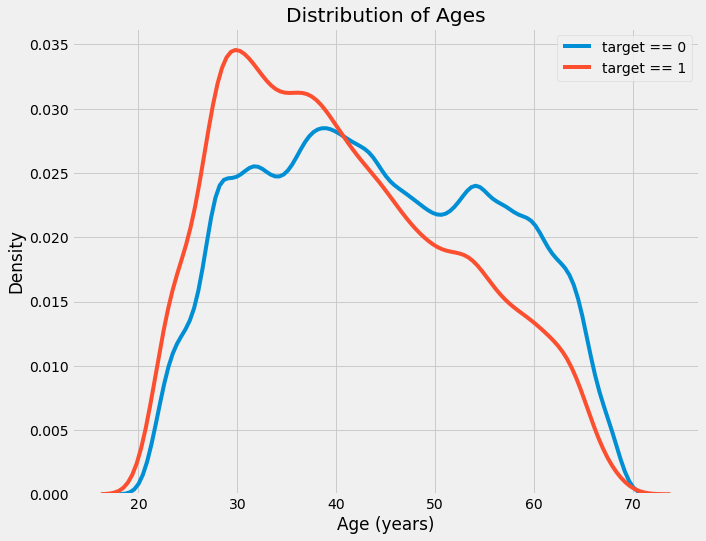

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(abs(df_origin.loc[df_origin['TARGET'] == 0, 'DAYS_BIRTH']) / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(abs(df_origin.loc[df_origin['TARGET'] == 1, 'DAYS_BIRTH']) / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

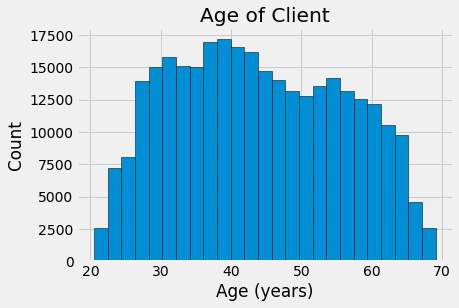

In [68]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(abs(df_origin['DAYS_BIRTH'] )/ 365, edgecolor = 'k', bins = 25) # abs()は絶対値の取得
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

###### 特徴量を追加作成して学習させると精度が上がる可能性がある。
<li>CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
<li>ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
<li>CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
<li>DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [211]:
#X_preprocessed_domain = X_preprocessed
#X_test_preprocessed_domain = X_test_preprocessed
#X_preprocessed_domain
#X_preprocessed_domain['CREDIT_INCOME_PERCENT'] = X_preprocessed_domain['AMT_CREDIT'] / X_preprocessed_domain['AMT_INCOME_TOTAL']

# 【問題4】高い汎化性能のモデル
##### これまで学んだことを用いながら汎化性能の高いモデルを作成してください。
##### 今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

※コードの量を抑えるため問題１から作成

※特徴量の加工は他の課題への応用性を考慮し、Kearnelにあった特徴量作成作業は含めず。

In [193]:
df_test = pd.read_csv('application_test.csv')

In [194]:
#object型のみ抽出
#データオブジェクトリストの作成
df_test_object_list = df_test.select_dtypes(include=object).columns

In [195]:
#one-hot encording
#データタイプがオブジェクトの特徴量をone-hot encodingする
ohe_test_columns = df_test_object_list
df_test_ohe = pd.get_dummies(df_test,
                       dummy_na=True, # NANもone-hotエンコーディングする
                       columns=ohe_test_columns)
df_test_ohe.head() #念のため表示して特徴量数を確認

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,1,0,0,1,0,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,1,0,0,1
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,1,0,0,1
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,1,0,0,0,1,0,0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,1,0,0,1


In [196]:
#データカラムの格納
X_test_columns = df_test_ohe.iloc[:,2:].columns.values

In [197]:
#モデルにあるカラムとテストデータにあるカラムの差を確認
cols_model = set(df_ohe.drop('TARGET', axis=1).columns.values)
cols_score = set(df_test_ohe.columns.values)

# モデルにはあったがテストデータにはないデータ項目
diff1 = cols_model - cols_score
print('モデルのみに存在する項目: %s' % diff1)

# テストデータにはあるがモデルになかったデータ項目
diff2 = cols_score - cols_model
print('テストデータのみに存在する項目: %s' % diff2)

モデルのみに存在する項目: {'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave', 'CODE_GENDER_XNA'}
テストデータのみに存在する項目: set()


In [198]:
#モデルデータのカラムをもったデータフレームを作成
df_cols_mix = pd.DataFrame(None,
                           columns=cols_model)
df_cols_mix

,OBS_60_CNT_SOCIAL_CIRCLE,FONDKAPREMONT_MODE_nan,NAME_TYPE_SUITE_Children,DEF_30_CNT_SOCIAL_CIRCLE,FONDKAPREMONT_MODE_reg oper account,ORGANIZATION_TYPE_Industry: type 1,NAME_EDUCATION_TYPE_Lower secondary,FLAG_DOCUMENT_18,CODE_GENDER_XNA,ORGANIZATION_TYPE_Electricity,...,REGION_POPULATION_RELATIVE,NONLIVINGAPARTMENTS_AVG,FLAG_DOCUMENT_5,OCCUPATION_TYPE_Sales staff,WALLSMATERIAL_MODE_Wooden,ENTRANCES_AVG,FLAG_OWN_CAR_nan,FLAG_DOCUMENT_13,LIVINGAREA_MEDI,NAME_INCOME_TYPE_Commercial associate


In [199]:
#モデルデータのカラムを持ったテストデータセットを作成
df_test_ohe_arranged = pd.concat([df_cols_mix, df_test_ohe])
print(df_test_ohe_arranged.shape)
df_test_ohe_arranged.head()

(48744, 261)


/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,20560.5,568800.0,450000.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0.9732,0.9732,0.9732,NaN,NaN,NaN
1,17370.0,222768.0,180000.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,69777.0,663264.0,630000.0,202500.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,49018.5,1575000.0,1575000.0,315000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0,0,1,0,0.9970,0.9970,0.9970,0.9592,0.9597,0.9608
4,32067.0,625500.0,625500.0,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
#テストデータにしかないカラムを削除する
df_test_ohe_arranged = df_test_ohe_arranged.drop(list(set(df_test_ohe.columns.values)-set(df_ohe.columns.values)),
                         axis=1)
df_test_ohe_arranged.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,20560.5,568800.0,450000.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0.9732,0.9732,0.9732,NaN,NaN,NaN
1,17370.0,222768.0,180000.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,69777.0,663264.0,630000.0,202500.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,49018.5,1575000.0,1575000.0,315000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0,0,1,0,0.9970,0.9970,0.9970,0.9592,0.9597,0.9608
4,32067.0,625500.0,625500.0,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
#テストデータにはなかったワンホットエンコーディングのラベルを全て０で埋める
df_test_ohe_arranged.loc[:,list(cols_model-cols_score)] = \
    df_test_ohe_arranged.loc[:,list(cols_model-cols_score)].fillna(0, axis=1)

#  列順をモデルのワンホットエンコーディングを行なった際の順番に変更
df_test_ohe_arranged = df_test_ohe_arranged.reindex_axis(df_ohe.drop('TARGET', axis=1).columns.values,axis=1)
df_test_ohe_arranged.head()

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,1,0,0,1,0,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,1,0,0,1
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,1,0,0,1
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,1,0,0,0,1,0,0
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,1,0,0,1


In [202]:
#データの配列格納
#説明変数は全て、目的変数はTARGET
X_test = df_test_ohe_arranged.iloc[:,1:].values

# 学習済みのImputerを適用し, X_testの欠損値を置き換える.
X_test_preprocessed = imp.transform(X_test)

# 臨時でカラムとデータフレームを作成して結果表示
pd.DataFrame(X_test_preprocessed,columns=X_columns).head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241.0,-2329.0,-5170.0,-812.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [203]:
#モデルの学習と適用
lgm.fit(X_preprocessed,y)
y_pred = lgm.predict_proba(X_test_preprocessed)

In [204]:
#提出用にデータ作成
submit = df_test_ohe_arranged[['SK_ID_CURR']]
submit['TARGET'] = y_pred[:,1]
submit.head()

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.035385
1,100005,0.103723
2,100013,0.018005
3,100028,0.035294
4,100038,0.152953


In [205]:
#CSVファイルに格納
submit.to_csv("submit_Home_Credit_Default_Risk.csv",index=None)

KAGGLE提出時のスコア:0.74268

特徴量は全て残し、ohe-hotエンコーディング

カテゴリカル変数のohe-hotエンコーディングに発生する新たな特徴量を含め、学習データとテストデータで齟齬がないように特徴量を調整

クロスバリデーションでのスコアは0.75〜0.76程度